In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
iot_data = pd.read_csv("/content/IOT-temp.csv")
iot_data

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In
...,...,...,...,...,...
97601,__export__.temp_log_91076_7fbd08ca,Room Admin,28-07-2018 07:07,31,In
97602,__export__.temp_log_147733_62c03f31,Room Admin,28-07-2018 07:07,31,In
97603,__export__.temp_log_100386_84093a68,Room Admin,28-07-2018 07:06,31,In
97604,__export__.temp_log_123297_4d8e690b,Room Admin,28-07-2018 07:06,31,In


## Step 1: Data Understanding and Preprocessing

### Checking Data Types

In [ ]:
# Check data types
print(iot_data.dtypes)


id            object
room_id/id    object
noted_date    object
temp           int64
out/in        object
dtype: object


`noted_date` converting to a datetime object for time series analysis.

`out/in` is a categorical variable.

### Converting `noted_date` to Datetime

In [ ]:
# Convert 'noted_date' to datetime
iot_data['noted_date'] = pd.to_datetime(iot_data['noted_date'], format='%d-%m-%Y %H:%M')


In [ ]:
iot_data['noted_date']

,noted_date
0,2018-12-08 09:30:00
1,2018-12-08 09:30:00
2,2018-12-08 09:29:00
3,2018-12-08 09:29:00
4,2018-12-08 09:29:00
...,...
97601,2018-07-28 07:07:00
97602,2018-07-28 07:07:00
97603,2018-07-28 07:06:00
97604,2018-07-28 07:06:00


### Sorting Data by Date


In [ ]:
# Sort the data by 'noted_date'
iot_data.sort_values('noted_date', inplace=True)
iot_data.reset_index(drop=True, inplace=True)


In [ ]:
iot_data

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_133741_32958703,Room Admin,2018-07-28 07:06:00,31,In
1,__export__.temp_log_123297_4d8e690b,Room Admin,2018-07-28 07:06:00,31,In
2,__export__.temp_log_100386_84093a68,Room Admin,2018-07-28 07:06:00,31,In
3,__export__.temp_log_118398_6ebe504d,Room Admin,2018-07-28 07:07:00,31,In
4,__export__.temp_log_144221_a4f20688,Room Admin,2018-07-28 07:07:00,31,In
...,...,...,...,...,...
97601,__export__.temp_log_196126_d30b72fb,Room Admin,2018-12-08 09:29:00,31,In
97602,__export__.temp_log_196128_be0919cf,Room Admin,2018-12-08 09:29:00,41,Out
97603,__export__.temp_log_196127_522915e3,Room Admin,2018-12-08 09:29:00,41,Out
97604,__export__.temp_log_196131_7bca51bc,Room Admin,2018-12-08 09:30:00,29,In


### Checking for Missing Values


In [ ]:
# Check for missing values
print(iot_data.isnull().sum())


id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64


### Handling Duplicates


In [ ]:
# Check for duplicate rows
print(f'Duplicate rows: {iot_data.duplicated().sum()}')

Duplicate rows: 1


In [ ]:
# Drop duplicate rows if any
iot_data.drop_duplicates(inplace=True)


### Statistical Summary


In [ ]:
# Get statistical summary
print(iot_data.describe())

                          noted_date          temp
count                          97605  97605.000000
mean   2018-10-07 05:09:43.782388224     35.053860
min              2018-07-28 07:06:00     21.000000
25%              2018-09-11 07:48:00     30.000000
50%              2018-10-17 05:10:00     35.000000
75%              2018-10-18 13:46:00     40.000000
max              2018-12-08 09:30:00     51.000000
std                              NaN      5.699811


### Exploratory Data Analysis (EDA)


#### Plotting Temperature Over Time

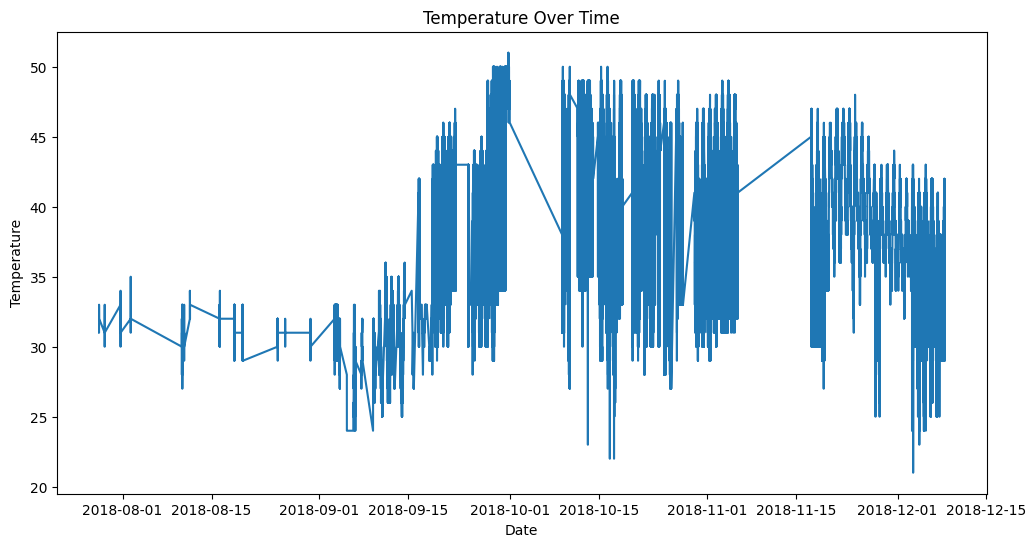

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(iot_data['noted_date'], iot_data['temp'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.show()


#### Distribution of Temperature

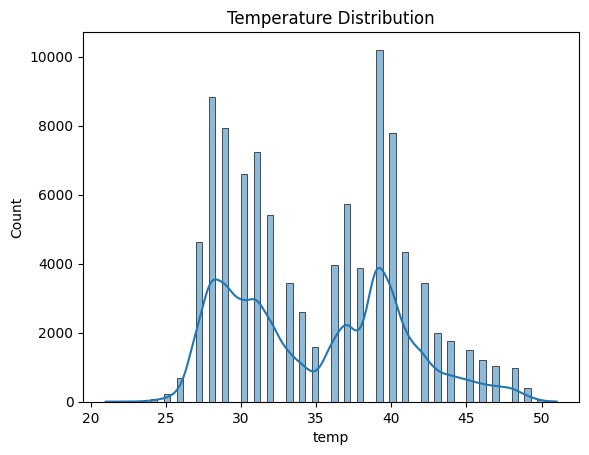

In [ ]:
sns.histplot(iot_data['temp'], kde=True)
plt.title('Temperature Distribution')
plt.show()


#### Boxplot to Detect Outliers

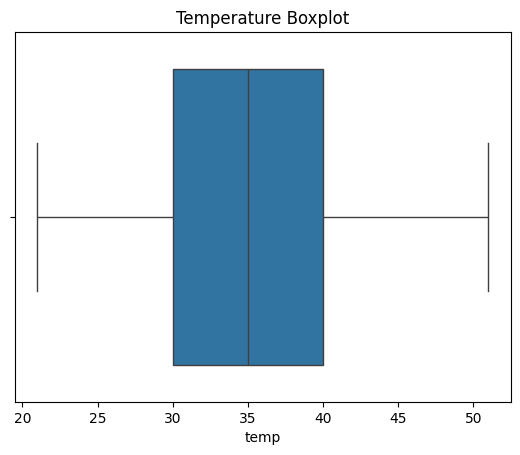

In [ ]:
sns.boxplot(x=iot_data['temp'])
plt.title('Temperature Boxplot')
plt.show()


### Feature Engineering

#### Extracting Date Features

In [ ]:
# Extract features from 'noted_date'
iot_data['year'] = iot_data['noted_date'].dt.year
iot_data['month'] = iot_data['noted_date'].dt.month
iot_data['day'] = iot_data['noted_date'].dt.day
iot_data['hour'] = iot_data['noted_date'].dt.hour
iot_data['minute'] = iot_data['noted_date'].dt.minute
iot_data['day_of_week'] = iot_data['noted_date'].dt.dayofweek


### Encoding Categorical Variables

In [ ]:
# Encode 'out/in' column
iot_data['out_in_encoded'] = iot_data['out/in'].map({'In': 1, 'Out': 0})


### Scaling and Normalizing Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Scale temperature values
iot_data['temp_scaled'] = scaler.fit_transform(iot_data[['temp']])

### Final Preprocessed DataFrame

In [ ]:
# Display the first few rows of the preprocessed DataFrame
iot_data.head()

,id,room_id/id,noted_date,temp,out/in,year,month,day,hour,minute,day_of_week,out_in_encoded,temp_scaled
0,__export__.temp_log_133741_32958703,Room Admin,2018-07-28 07:06:00,31,In,2018,7,28,7,6,5,1,0.333333
1,__export__.temp_log_123297_4d8e690b,Room Admin,2018-07-28 07:06:00,31,In,2018,7,28,7,6,5,1,0.333333
2,__export__.temp_log_100386_84093a68,Room Admin,2018-07-28 07:06:00,31,In,2018,7,28,7,6,5,1,0.333333
3,__export__.temp_log_118398_6ebe504d,Room Admin,2018-07-28 07:07:00,31,In,2018,7,28,7,7,5,1,0.333333
4,__export__.temp_log_144221_a4f20688,Room Admin,2018-07-28 07:07:00,31,In,2018,7,28,7,7,5,1,0.333333


## Step 2: Baseline Model Development Using LSTM


### Prepare the Data for LSTM


The LSTM model requires input in a 3D format: (samples, time steps, features).

Let's first prepare the data.

In [ ]:
# Preparing the data: using 'temp_scaled' for forecasting
# Predicting the next 10-minute values
sequence_length = 10

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Use 'temp_scaled' column to create sequences
data = iot_data['temp_scaled'].values
X, y = create_sequences(data, sequence_length)


In [ ]:
data

array([0.33333333, 0.33333333, 0.33333333, ..., 0.66666667, 0.26666667,
       0.26666667])

### Splitting Data into Train and Test Sets


Splitting the data into training and test sets to evaluate the model.

In [ ]:
# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### Building the LSTM Model


Building a simple LSTM model as our baseline.

In [ ]:
# Defining the LSTM model
model = Sequential()

# Adding an LSTM layer with 50 units and a Dropout layer to prevent overfitting
model.add(LSTM(50, return_sequences=False, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))

# Output layer to predict the next temperature value
model.add(Dense(1))

# Compiling the model with mean squared error loss and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model


Training the model for a few epochs to observe its performance.

In [ ]:
# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Fitting the model

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0103 - val_loss: 0.0199
Epoch 2/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0045 - val_loss: 0.0198
Epoch 3/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0042 - val_loss: 0.0196
Epoch 4/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0042 - val_loss: 0.0193
Epoch 5/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0042 - val_loss: 0.0195
Epoch 6/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0041 - val_loss: 0.0196
Epoch 7/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0042 - val_loss: 0.0195
Epoch 8/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0043 - val_loss: 0.0199
Epoch 9/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0040 - val_loss: 0.0198
Epoch 10/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0041 - val_loss: 0.0193
Epoch 11/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0041 - val_loss: 0.0195
Epoch 12/20
2440/24

### Evaluating the Model


After training the model, evaluating its performance using MAE, MSE, and RMSE.

In [ ]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# Inverse scaling the predictions and actual values (optional if scaling was applied)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAE: 2.8794553458577656
MSE: 17.47682129661469
RMSE: 4.180528829779157


### Visualizing the Results


Finally, we can visualize the predicted vs actual temperature values to observe how well the model performed.

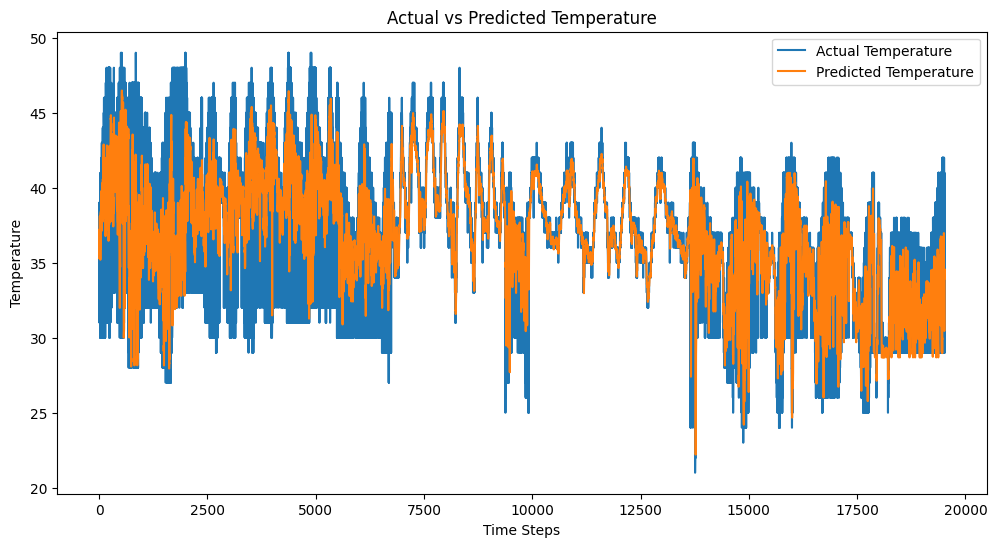

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


**Explanation of the Baseline Model**
* **LSTM Layer:** The model uses an LSTM layer with 50 units, which is ideal for capturing temporal dependencies in time series data.
* **Dropout Layer:** A dropout of 20% helps in preventing overfitting.
* **Dense Layer:** The output layer predicts the next temperature value.
* **Loss Function:** We use Mean Squared Error (MSE) as the loss function.
* **Optimizer:** The Adam optimizer is used for training.

## Step 2: Baseline Model Development Using LSTM with feature extraction

#### Dropping unnecessary columns

In [ ]:
# Display the first few rows of the preprocessed DataFrame
iot_data = iot_data[['out_in_encoded', 'temp_scaled', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week']]
iot_data

,out_in_encoded,temp_scaled,year,month,day,hour,minute,day_of_week
0,1,0.333333,2018,7,28,7,6,5
1,1,0.333333,2018,7,28,7,6,5
2,1,0.333333,2018,7,28,7,6,5
3,1,0.333333,2018,7,28,7,7,5
4,1,0.333333,2018,7,28,7,7,5
...,...,...,...,...,...,...,...,...
97601,1,0.333333,2018,12,8,9,29,5
97602,0,0.666667,2018,12,8,9,29,5
97603,0,0.666667,2018,12,8,9,29,5
97604,1,0.266667,2018,12,8,9,30,5


**Summary of Preprocessing Steps**
* Converted `noted_date` to datetime format.
* Sorted data by `noted_date`.
* Checked and handled missing values and duplicates.
* Extracted additional time-based features.
* Encoded categorical variables.
* Scaled the temperature values.

### Prepare the Data for LSTM


The LSTM model requires input in a 3D format: (samples, time steps, features).

Let's first prepare the data.

In [ ]:
# Preparing the data: using 'temp_scaled' for forecasting
# Predicting the next 10-minute values
sequence_length = 10

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Use 'temp_scaled' column to create sequences
data = iot_data['temp_scaled'].values
X, y = create_sequences(data, sequence_length)


In [ ]:
data

array([0.33333333, 0.33333333, 0.33333333, ..., 0.66666667, 0.26666667,
       0.26666667])

### Splitting Data into Train and Test Sets


Splitting the data into training and test sets to evaluate the model.

In [ ]:
# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### Building the LSTM Model


Building a simple LSTM model as our baseline.

In [ ]:
# Defining the LSTM model
model = Sequential()

# Adding an LSTM layer with 50 units and a Dropout layer to prevent overfitting
model.add(LSTM(50, return_sequences=False, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))

# Output layer to predict the next temperature value
model.add(Dense(1))

# Compiling the model with mean squared error loss and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model


Training the model for a few epochs to observe its performance.

In [ ]:
# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Fitting the model

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0096 - val_loss: 0.0197
Epoch 2/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0046 - val_loss: 0.0195
Epoch 3/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0042 - val_loss: 0.0196
Epoch 4/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0042 - val_loss: 0.0200
Epoch 5/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0041 - val_loss: 0.0193
Epoch 6/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0041 - val_loss: 0.0194
Epoch 7/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0041 - val_loss: 0.0195
Epoch 8/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0041 - val_loss: 0.0197
Epoch 9/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0042 - val_loss: 0.0197
Epoch 10/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0043 - val_loss: 0.0195
Epoch 11/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0041 - val_loss: 0.0194
Epoch 12/20
2440/24

### Evaluating the Model


After training the model, evaluating its performance using MAE, MSE, and RMSE.

In [ ]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# Inverse scaling the predictions and actual values (optional if scaling was applied)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAE: 2.847308484029621
MSE: 17.677397441407603
RMSE: 4.204449719215061


### Visualizing the Results


Finally, we can visualize the predicted vs actual temperature values to observe how well the model performed.

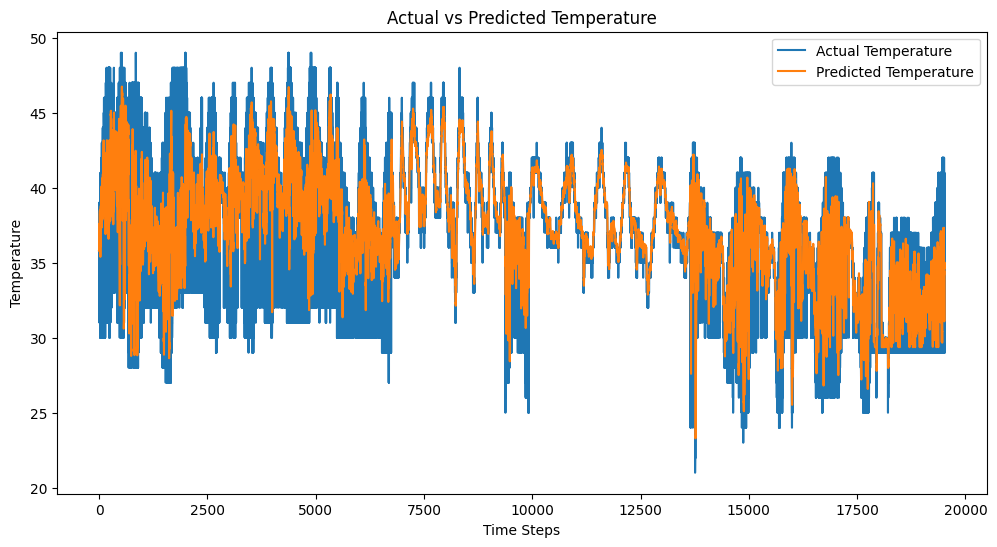

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


**Explanation of the Baseline Model**
* **LSTM Layer:** The model uses an LSTM layer with 50 units, which is ideal for capturing temporal dependencies in time series data.
* **Dropout Layer:** A dropout of 20% helps in preventing overfitting.
* **Dense Layer:** The output layer predicts the next temperature value.
* **Loss Function:** We use Mean Squared Error (MSE) as the loss function.
* **Optimizer:** The Adam optimizer is used for training.

## 3. Experimentation for Improvement


### Experiment 1: Hyperparameter Tuning

1. Adjust Learning Rates

We'll try two learning rates (0.001 and 0.0005).

2. Experiment with Batch Sizes

We'll experiment with batch sizes of 32 and 64.

3. Test Different Optimizers

We'll test Adam and SGD optimizers, which are commonly used for time series forecasting tasks.

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

# Define the learning rates and batch sizes to experiment with
learning_rates = [0.001, 0.0005]

# Define optimizers to experiment with
optimizers = [Adam(learning_rate=lr) for lr in learning_rates] + [SGD(learning_rate=lr) for lr in learning_rates]

# Loop over each optimizer and batch size combination
for optimizer in optimizers:

    # Rebuild the model to reset it
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # Compile the model with the optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    print(f"Training model with optimizer: {optimizer}")

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Evaluate the model on the validation data
    val_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Validation Loss: {val_loss}")


Training model with optimizer: <keras.src.optimizers.adam.Adam object at 0x79423a8dac80>
Epoch 1/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0093 - val_loss: 0.0198
Epoch 2/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0041 - val_loss: 0.0197
Epoch 3/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0041 - val_loss: 0.0198
Epoch 4/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0041 - val_loss: 0.0201
Epoch 5/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.0040 - val_loss: 0.0198
Epoch 6/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0038 - val_loss: 0.0197
Epoch 7/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0040 - val_loss: 0.0198
Epoch 8/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0039 - val_loss: 0.0197
Epoch 9/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0039 - val_loss: 0.0197
Epoch 10/20
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0038 - val_loss: 0.0196
Epoch 11/20
2440/244

### Experiment 2: Model Architecture Enhancement


Step 1: Stacking LSTM Layers

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

# Define a new model with stacked LSTM layers
model = Sequential()

# Add the first LSTM layer (return_sequences=True to stack layers)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add a second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Add a third LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Final dense output layer
model.add(Dense(1))  # Output layer for regression task (temperature prediction)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - loss: 0.0133 - val_loss: 0.0206
Epoch 2/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0050 - val_loss: 0.0202
Epoch 3/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0047 - val_loss: 0.0200
Epoch 4/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.0044 - val_loss: 0.0198
Epoch 5/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 0.0044 - val_loss: 0.0196
Epoch 6/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.0043 - val_loss: 0.0198
Epoch 7/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.0043 - val_loss: 0.0195
Epoch 8/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0043 - val_loss: 0.0194
Epoch 9/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0041 - val_loss: 0.0197
Epoch 10/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0042 - val_loss: 0.0198
Epoch 11/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0042 - val_loss: 0.0196
Epoch 12

Step 2: Adding Bidirectional LSTM


In [ ]:
# Define a new model with bidirectional LSTM
model = Sequential()

# Add bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add a second bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.2))

# Final dense output layer
model.add(Dense(1))  # Output layer for regression task (temperature prediction)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - loss: 0.0097 - val_loss: 0.0194
Epoch 2/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 0.0047 - val_loss: 0.0193
Epoch 3/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 0.0044 - val_loss: 0.0195
Epoch 4/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.0043 - val_loss: 0.0195
Epoch 5/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0042 - val_loss: 0.0195
Epoch 6/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - loss: 0.0042 - val_loss: 0.0197
Epoch 7/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.0041 - val_loss: 0.0193
Epoch 8/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.0041 - val_loss: 0.0195
Epoch 9/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0041 - val_loss: 0.0195
Epoch 10/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 0.0041 - val_loss: 0.0198
Epoch 11/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0040 - val_loss: 0.0199
Epoch 12

In [ ]:
from sklearn.preprocessing import LabelEncoder


In [ ]:
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Random Forest Regressor

In [ ]:
iot_data

,out_in_encoded,temp_scaled,year,month,day,hour,minute,day_of_week
0,1,0.333333,2018,7,28,7,6,5
1,1,0.333333,2018,7,28,7,6,5
2,1,0.333333,2018,7,28,7,6,5
3,1,0.333333,2018,7,28,7,7,5
4,1,0.333333,2018,7,28,7,7,5
...,...,...,...,...,...,...,...,...
97601,1,0.333333,2018,12,8,9,29,5
97602,0,0.666667,2018,12,8,9,29,5
97603,0,0.666667,2018,12,8,9,29,5
97604,1,0.266667,2018,12,8,9,30,5


In [ ]:
iot_data = pd.read_csv("/content/IOT-temp.csv")
iot_data

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In
...,...,...,...,...,...
97601,__export__.temp_log_91076_7fbd08ca,Room Admin,28-07-2018 07:07,31,In
97602,__export__.temp_log_147733_62c03f31,Room Admin,28-07-2018 07:07,31,In
97603,__export__.temp_log_100386_84093a68,Room Admin,28-07-2018 07:06,31,In
97604,__export__.temp_log_123297_4d8e690b,Room Admin,28-07-2018 07:06,31,In


In [ ]:
label_encoder = LabelEncoder()

iot_data['out/in'] = label_encoder.fit_transform(iot_data['out/in'])

In [ ]:
# Convert 'noted_date' to datetime
iot_data['noted_date'] = pd.to_datetime(iot_data['noted_date'], format='%d-%m-%Y %H:%M')


In [ ]:
# Sort the data by 'noted_date'
iot_data.sort_values('noted_date', inplace=True)
iot_data.reset_index(drop=True, inplace=True)


In [ ]:
# Drop duplicate rows if any
iot_data.drop_duplicates(inplace=True)


In [ ]:
# Extract features from 'noted_date'
iot_data['year'] = iot_data['noted_date'].dt.year
iot_data['month'] = iot_data['noted_date'].dt.month
iot_data['day'] = iot_data['noted_date'].dt.day
iot_data['hour'] = iot_data['noted_date'].dt.hour
iot_data['minute'] = iot_data['noted_date'].dt.minute
iot_data['day_of_week'] = iot_data['noted_date'].dt.dayofweek


In [ ]:
iot_data

,id,room_id/id,noted_date,temp,out/in,year,month,day,hour,minute,day_of_week
0,__export__.temp_log_133741_32958703,Room Admin,2018-07-28 07:06:00,31,0,2018,7,28,7,6,5
1,__export__.temp_log_123297_4d8e690b,Room Admin,2018-07-28 07:06:00,31,0,2018,7,28,7,6,5
2,__export__.temp_log_100386_84093a68,Room Admin,2018-07-28 07:06:00,31,0,2018,7,28,7,6,5
3,__export__.temp_log_118398_6ebe504d,Room Admin,2018-07-28 07:07:00,31,0,2018,7,28,7,7,5
4,__export__.temp_log_144221_a4f20688,Room Admin,2018-07-28 07:07:00,31,0,2018,7,28,7,7,5
...,...,...,...,...,...,...,...,...,...,...,...
97601,__export__.temp_log_196126_d30b72fb,Room Admin,2018-12-08 09:29:00,31,0,2018,12,8,9,29,5
97602,__export__.temp_log_196128_be0919cf,Room Admin,2018-12-08 09:29:00,41,1,2018,12,8,9,29,5
97603,__export__.temp_log_196127_522915e3,Room Admin,2018-12-08 09:29:00,41,1,2018,12,8,9,29,5
97604,__export__.temp_log_196131_7bca51bc,Room Admin,2018-12-08 09:30:00,29,0,2018,12,8,9,30,5


In [ ]:
X = iot_data[['month','day','year','hour','minute','out/in']]
y = iot_data['temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
predicted_temps = model.predict(X_test)

mse = mean_squared_error(y_test, predicted_temps)
r2 = r2_score(y_test, predicted_temps)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.28492397226982663
R-squared Score: 0.9913182846905624


### Decision Tree Regressor

In [ ]:
# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Test MSE: {mse}, Test RMSE: {rmse}")

Test MSE: 0.35941890820777705, Test RMSE: 0.5995155612724136


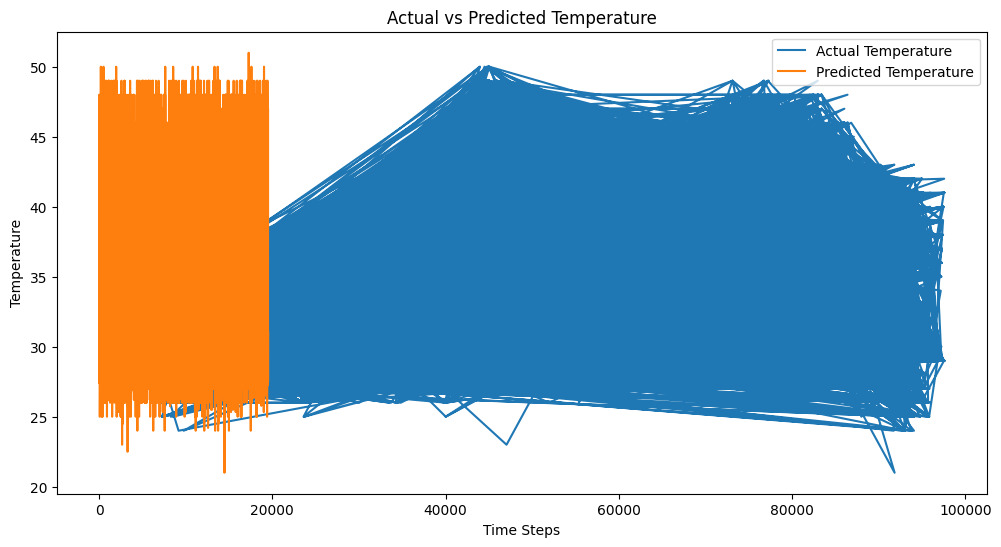

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


## ANN

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Split the data
X = iot_data[['month', 'day', 'year', 'hour', 'minute', 'out/in']]
y = iot_data['temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))

# Hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test MSE: {mse}, Test RMSE: {rmse}")


Epoch 1/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 194.1538 - val_loss: 4.1692
Epoch 2/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.7248 - val_loss: 2.8441
Epoch 3/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.7498 - val_loss: 2.3780
Epoch 4/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2.3360 - val_loss: 2.0846
Epoch 5/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.0627 - val_loss: 1.9007
Epoch 6/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.8063 - val_loss: 1.7843
Epoch 7/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.6486 - val_loss: 1.5839
Epoch 8/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.5745 - val_loss: 1.3503
Epoch 9/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.4823 - val_loss: 1.3479
Epoch 10/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.4194 - val_loss: 1.2764
Epoch 11/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.3955 - val_loss: 1.5121
Epoch 12/20
2441/2441 ━━━━━

## Stacking

### 1. Build LSTM Model:


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Prepare Data
X = iot_data[['month', 'day', 'year', 'hour', 'minute', 'out/in']].values
y = iot_data['temp'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM input
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Compile and train the model
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))

# Get LSTM predictions
lstm_train_pred = lstm_model.predict(X_train_lstm)
lstm_test_pred = lstm_model.predict(X_test_lstm)


Epoch 1/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1207.5134 - val_loss: 33.2477
Epoch 2/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 96.8095 - val_loss: 27.0464
Epoch 3/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 88.1006 - val_loss: 23.5571
Epoch 4/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 80.1274 - val_loss: 23.1687
Epoch 5/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 72.2438 - val_loss: 22.4832
Epoch 6/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 66.8448 - val_loss: 21.2821
Epoch 7/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 59.9635 - val_loss: 22.2834
Epoch 8/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 54.4327 - val_loss: 17.8122
Epoch 9/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 49.3345 - val_loss: 18.1432
Epoch 10/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 45.2123 - val_loss: 17.2494
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


### 2. Build ANN Model:


In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense

# Scale the data
scaler = StandardScaler()
X_train_ann = scaler.fit_transform(X_train)
X_test_ann = scaler.transform(X_test)

# Build ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train_ann.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1))

# Compile and train the model
ann_model.compile(optimizer='adam', loss='mse')
ann_model.fit(X_train_ann, y_train, epochs=10, batch_size=32, validation_data=(X_test_ann, y_test))

# Get ANN predictions
ann_train_pred = ann_model.predict(X_train_ann)
ann_test_pred = ann_model.predict(X_test_ann)


Epoch 1/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 262.9140 - val_loss: 7.2776
Epoch 2/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.2358 - val_loss: 4.5307
Epoch 3/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4.2408 - val_loss: 3.6306
Epoch 4/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 3.5456 - val_loss: 3.2476
Epoch 5/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.1346 - val_loss: 3.0204
Epoch 6/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.9231 - val_loss: 2.7434
Epoch 7/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.6657 - val_loss: 2.5533
Epoch 8/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.4847 - val_loss: 2.3901
Epoch 9/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.3049 - val_loss: 2.1800
Epoch 10/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.1490 - val_loss: 2.0591
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### 3. Combine LSTM and ANN Predictions:


In [ ]:
# Combine the LSTM and ANN predictions as input for XGBoost
train_combined = np.hstack((lstm_train_pred, ann_train_pred))
test_combined = np.hstack((lstm_test_pred, ann_test_pred))


### 4. Train XGBoost Model:


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(train_combined, y_train)

# Make predictions with XGBoost
xgb_train_pred = xgb_model.predict(train_combined)
xgb_test_pred = xgb_model.predict(test_combined)

# Evaluate performance
mse = mean_squared_error(y_test, xgb_test_pred)
rmse = np.sqrt(mse)
print(f"XGBoost Test MSE: {mse}, Test RMSE: {rmse}")


XGBoost Test MSE: 0.9369685575612245, Test RMSE: 0.9679713619530407


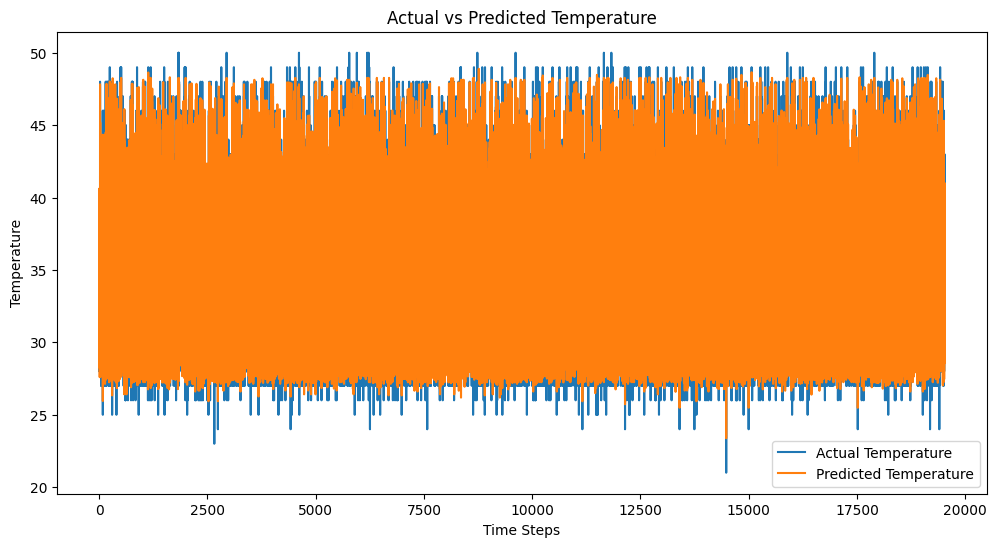

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Temperature')
plt.plot(xgb_test_pred, label='Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


## LSTM model training on "In" and "Out" categories

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score

Removing unnecessary columns

In [ ]:
iot_data_new = iot_data.drop(['id', 'room_id/id'], axis=1)

Extracting values of temperature according to "In" and "Out" categories.

In [ ]:
in_temperatures = iot_data_new[iot_data_new["out/in"] == 0][["temp"]]
out_temperatures = iot_data_new[iot_data_new["out/in"] == 1][["temp"]]

Scaling the features

In [ ]:
in_scaler = MinMaxScaler()
out_scaler = MinMaxScaler()

in_temperatures_scaled = in_scaler.fit_transform(in_temperatures)
out_temperatures_scaled = out_scaler.fit_transform(out_temperatures)

Splitting dataset for training set

In [ ]:
in_train_size = int(len(in_temperatures_scaled) * 0.8)
out_train_size = int(len(out_temperatures_scaled) * 0.8)

Splitting dataset for testing set

In [ ]:
in_test_size = len(in_temperatures_scaled) - in_train_size
out_test_size = len(out_temperatures_scaled) - out_train_size

In [ ]:
print("In Train Size:", in_train_size)
print("In Test Size:", in_test_size)
print("Out Train Size:", out_train_size)
print("Out Test Size:", out_test_size)

In Train Size: 16276
In Test Size: 4069
Out Train Size: 61808
Out Test Size: 15452


Scaling

In [ ]:
in_train = in_temperatures_scaled[0:in_train_size, :]
in_test = in_temperatures_scaled[in_train_size:len(in_temperatures_scaled), :]

In [ ]:
out_train = out_temperatures_scaled[0:out_train_size, :]
out_test = out_temperatures_scaled[out_train_size:len(out_temperatures_scaled), :]

Preparing dataset for training

In [ ]:
def dataset(data, steps=1):
    data_x, data_y = [], []
    for i in range(len(data) - steps - 1):
        a = data[i:(i + steps), 0]
        b = data[i + steps, 0]
        data_x.append(a)
        data_y.append(b)

    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return data_x, data_y

In [ ]:
X_train_in, y_train_in = dataset(in_train)
X_test_in, y_test_in = dataset(in_test)

In [ ]:
X_train_out, y_train_out = dataset(out_train)
X_test_out, y_test_out = dataset(out_test)

Building models for "In" and "Out".

In [ ]:
in_model = Sequential()
in_model.add(LSTM(16, input_shape=(1, 1)))
in_model.add(Dense(1))
in_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [ ]:
out_model = Sequential()
out_model.add(LSTM(64, input_shape=(1, 1)))
out_model.add(Dense(1))
out_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Define the model checkpoint callback
checkpoint_callback_in = ModelCheckpoint(
    filepath='best_model_in.keras',  # Path to save the best model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save the model only when val_loss improves
    mode='min',                # Mode to monitor val_loss (minimize)
    verbose=1                  # Print updates during training
)

In [ ]:
# Define the model checkpoint callback
checkpoint_callback_out = ModelCheckpoint(
    filepath='best_model_out.keras',  # Path to save the best model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save the model only when val_loss improves
    mode='min',                # Mode to monitor val_loss (minimize)
    verbose=1                  # Print updates during training
)

Adding EarlyStopping

In [ ]:
early = EarlyStopping(monitor="val_loss", patience=3)

Fitting the models

In [ ]:
in_history = in_model.fit(X_train_in, y_train_in, epochs=100, validation_split=0.2, callbacks=[early, checkpoint_callback_in])

Epoch 1/100
406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0936
Epoch 1: val_loss improved from inf to 0.00580, saving model to best_model_in.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0933 - val_accuracy: 0.0000e+00 - val_loss: 0.0058
Epoch 2/100
401/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0048
Epoch 2: val_loss improved from 0.00580 to 0.00413, saving model to best_model_in.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0048 - val_accuracy: 0.0000e+00 - val_loss: 0.0041
Epoch 3/100
393/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0028
Epoch 3: val_loss improved from 0.00413 to 0.00294, saving model to best_model_in.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0028 - val_accuracy: 0.0000e+00 - val_loss: 0.0029
Epoch 4/100
403/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0014
E

In [ ]:
out_history = out_model.fit(X_train_out, y_train_out, epochs=100, validation_split=0.2, callbacks=[early, checkpoint_callback_out])

Epoch 1/100
1544/1546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 8.3347e-05 - loss: 0.0250
Epoch 1: val_loss improved from inf to 0.00051, saving model to best_model_out.keras
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 8.3421e-05 - loss: 0.0249 - val_accuracy: 0.0000e+00 - val_loss: 5.0863e-04
Epoch 2/100
1543/1546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.9730e-05 - loss: 6.7048e-04
Epoch 2: val_loss improved from 0.00051 to 0.00044, saving model to best_model_out.keras
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 7.9837e-05 - loss: 6.7049e-04 - val_accuracy: 0.0000e+00 - val_loss: 4.4178e-04
Epoch 3/100
1534/1546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0486e-04 - loss: 6.8723e-04
Epoch 3: val_loss improved from 0.00044 to 0.00043, saving model to best_model_out.keras
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0500e-04 - loss: 6.8707e-04 - val_accuracy: 0.0000e+00 - val_loss: 4.2950e-04
Epoch 4/100
1533/1546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

Making predictions

In [ ]:
y_pred_in = in_model.predict(X_test_in)
y_pred_in = in_scaler.inverse_transform(y_pred_in)

y_test_in = y_test_in.reshape(-1, 1)
y_test_in = in_scaler.inverse_transform(y_test_in)
print("R2 Score:", r2_score(y_test_in, y_pred_in))

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
R2 Score: 0.9259323994912139


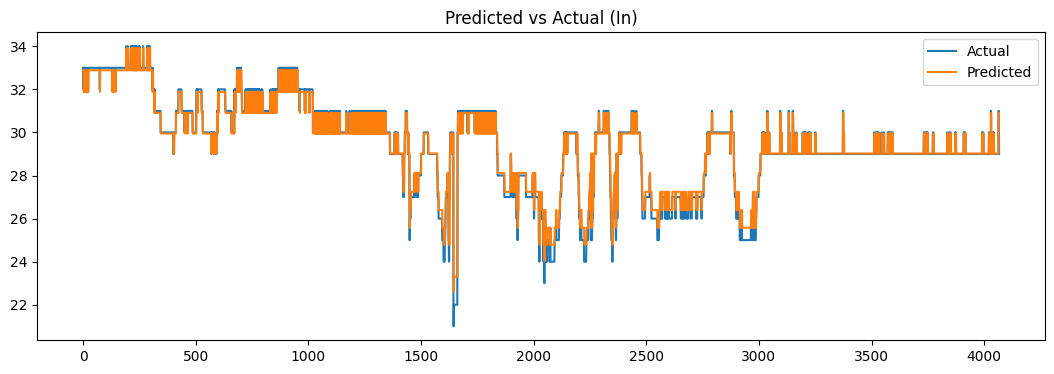

In [ ]:
plt.figure(figsize=(13, 4))
plt.plot(y_test_in, label="Actual")
plt.plot(y_pred_in, label="Predicted")
plt.title("Predicted vs Actual (In)")
plt.legend()
plt.show()

In [ ]:
y_pred_out = out_model.predict(X_test_out)
y_pred_out = out_scaler.inverse_transform(y_pred_out)

y_test_out = y_test_out.reshape(-1, 1)
y_test_out = out_scaler.inverse_transform(y_test_out)
print("R2 Score:", r2_score(y_test_out, y_pred_out))

483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R2 Score: 0.9518967665889041


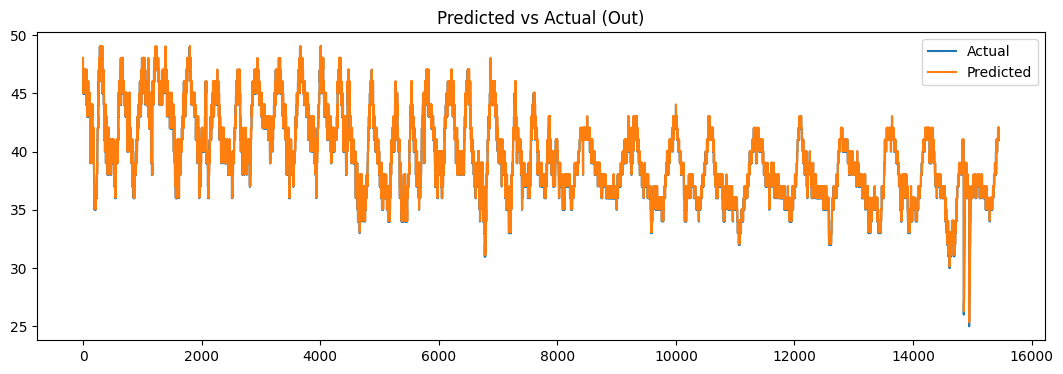

In [ ]:
plt.figure(figsize=(13, 4))
plt.plot(y_test_out, label="Actual")
plt.plot(y_pred_out, label="Predicted")
plt.title("Predicted vs Actual (Out)")
plt.legend()
plt.show()

## Step 4: Checkpoint Mechanism and Retraining Strategy

**Retraining Strategy:**

In real-world applications, new data becomes available continuously, which may cause the model to degrade if it's not updated periodically. A retraining strategy ensures the model stays relevant with evolving data patterns.

* **Handling New Data:** New incoming data can be stored in a buffer or a database, and retraining can occur periodically (e.g., daily, weekly) or after a specific volume of new data has been collected.

* **Approaches to Retraining:**

  * **Full Retraining:** Re-train the entire model with both the new and old data. This ensures the model incorporates both past and current trends but may be computationally expensive.

  * **Incremental Learning:** Retrain only on the new data, adjusting the model slightly to accommodate new patterns without forgetting old data. This is useful when new data arrives frequently.

  * **Transfer Learning:** Freeze earlier layers of the model and retrain only the later layers with new data. This is often useful when the model has learned robust low-level features that don't change over time.

**Handling Model Performance Degradation:**

Over time, the performance of the model may degrade due to changing data distributions, also known as "data drift" or "concept drift."

* **Monitoring Performance:** Regularly monitor the model’s performance on a validation set. If performance drops beyond a certain threshold, initiate retraining.

* **Automated Alerts:** Set up alerts to notify when the model performance falls below a defined level (e.g., a sudden spike in loss or error metrics).

* **Validation on New Data:** Before deploying a retrained model, validate it on a holdout test set or use k-fold cross-validation to ensure the model hasn't overfitted to new data.

**Scenario Handling:**

* **Gradual Drift:** Retrain the model periodically (e.g., weekly or monthly) to address small, gradual changes in the data.

* **Sudden Shift:** If there’s a sudden change in the data (e.g., due to external factors), re-train the model immediately on the new data, and possibly fine-tune certain parts of the model architecture to adapt to the new patterns.

* **Model Ensemble:** To prevent performance degradation, consider using model ensembles. Combining predictions from multiple models can make the system more resilient to shifts in the data and improve generalization.